In [1]:
import numpy as np
import pandas as pd
import cv2
import keras.backend as K
from collections import OrderedDict
import os
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score

from lib import quantification
from lib import help_functions


#test_data = 'conj_hrf'
result_dir = 'augReduceLr_conjHrf'


default_result_path = './result/'
name_experiment = 'figure5/figure5_'+result_dir+'/'

grd_mode = 'hrf'
grd_path = './data/figure5_result/' + grd_mode+'/test/ground_truth/'

SEG_MAP_PATH = default_result_path+name_experiment+'hrf_predicted_imgs/'
GRD_MAP_PATH =  grd_path


Using TensorFlow backend.
/home/bono/.pyenv/versions/3.5.5/envs/gpuTest/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/bono/.pyenv/versions/3.5.5/envs/gpuTest/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:520: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/bono/.pyenv/versions/3.5.5/envs/gpuTest/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:521: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np

In [2]:
def load_vessel_ori_map(ORI_PATH, num_imgs, shape_imgs, crop_flag = False, crop_size = None):
    RESIZE_CONSTANT = 0.5
    HEIGHT_IMG = int(1848 * RESIZE_CONSTANT)
    WIDTH_IMG = int(2208 *RESIZE_CONSTANT)
    
    
    img_h, img_w = shape_imgs[0], shape_imgs[1]
    ori_vessel_imgs = np.zeros((num_imgs, img_h, img_w),dtype=np.uint8)    
    idx =0 
    print('ori vessel imgs shape : ', np.shape(ori_vessel_imgs))
    for count, filename in enumerate(sorted(os.listdir(ORI_PATH)), start=0):
        if filename.startswith(".ipynb") == False:
            print(ORI_PATH + filename)
            temp = cv2.imread(ORI_PATH + filename)[:,:,0]
            temp = cv2.resize(temp, (WIDTH_IMG, HEIGHT_IMG), interpolation = cv2.INTER_CUBIC)
            if crop_flag == True:
                temp = temp[0:crop_size[0]-54, 5:crop_size[1]-64]
              
            
            print(ORI_PATH + filename)
            ret,thresh = cv2.threshold(temp,100,1,cv2.THRESH_BINARY)
            ori_vessel_imgs[idx] = temp.astype(np.uint8)
            idx = idx+1
            
    return ori_vessel_imgs

def load_vessel_seg_map(SEG_PATH, num_imgs, shape_imgs, thr_val = 100, crop_flag = False, crop_size = None):
    img_h, img_w = shape_imgs[0], shape_imgs[1]
    seg_vessel_imgs = np.zeros((num_imgs, img_h, img_w),dtype=np.uint8)    
    print('seg vessel imgs shape : ',np.shape(seg_vessel_imgs))
    idx =0 
    
    for count, filename in enumerate(sorted(os.listdir(SEG_PATH)), start=0):
        if filename.startswith(".ipynb") == False:
            temp = (cv2.imread(SEG_PATH + filename))[:,:,0]
            print(SEG_PATH + filename)
            if crop_flag == True:
                temp = temp[0:crop_size[0]-54 , 5:crop_size[1]-64]
            ret,thresh = cv2.threshold(temp,100,1,cv2.THRESH_BINARY)
#            thresh = np.array(thresh,np.uint8)


            seg_vessel_imgs[idx] = thresh
            
            idx = idx+1
            
    return seg_vessel_imgs

def count_num_files(FILE_PATH):
    num_files = 0
    for count, filename in enumerate(sorted(os.listdir(FILE_PATH)), start=0):
        if filename.startswith(".ipynb") == False:
            num_files = num_files+1
    return num_files

def get_shape_of_imgs(SEG_PATH):
    for count, filename in enumerate(sorted(os.listdir(SEG_PATH)), start=0):
        if filename.startswith(".ipynb") == False:
            temp_imgs = cv2.imread(SEG_PATH + filename)
            return np.shape(temp_imgs)
                    
def crop_get_shape_of_imgs(SEG_PATH, crop_size):
    for count, filename in enumerate(sorted(os.listdir(SEG_PATH)), start=0):
        if filename.startswith(".ipynb") == False:
            temp_imgs = cv2.imread(SEG_PATH + filename)
            temp_imgs = temp_imgs[0:crop_size[0], 0:crop_size[1], :]
            return np.shape(temp_imgs)

seg vessel imgs shape :  (30, 820, 985)
./result/figure5/figure5_augReduceLr_conjHrf/hrf_predicted_imgs/03_predict.png
./result/figure5/figure5_augReduceLr_conjHrf/hrf_predicted_imgs/04_predict.png
./result/figure5/figure5_augReduceLr_conjHrf/hrf_predicted_imgs/05_predict.png
./result/figure5/figure5_augReduceLr_conjHrf/hrf_predicted_imgs/06_predict.png
./result/figure5/figure5_augReduceLr_conjHrf/hrf_predicted_imgs/07_predict.png
./result/figure5/figure5_augReduceLr_conjHrf/hrf_predicted_imgs/08_predict.png
./result/figure5/figure5_augReduceLr_conjHrf/hrf_predicted_imgs/09_predict.png
./result/figure5/figure5_augReduceLr_conjHrf/hrf_predicted_imgs/10_predict.png
./result/figure5/figure5_augReduceLr_conjHrf/hrf_predicted_imgs/11_predict.png
./result/figure5/figure5_augReduceLr_conjHrf/hrf_predicted_imgs/13_predict.png
./result/figure5/figure5_augReduceLr_conjHrf/hrf_predicted_imgs/14_predict.png
./result/figure5/figure5_augReduceLr_conjHrf/hrf_predicted_imgs/15_predict.png
./result/fig

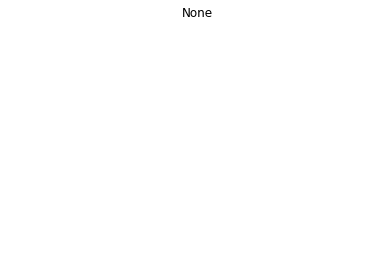

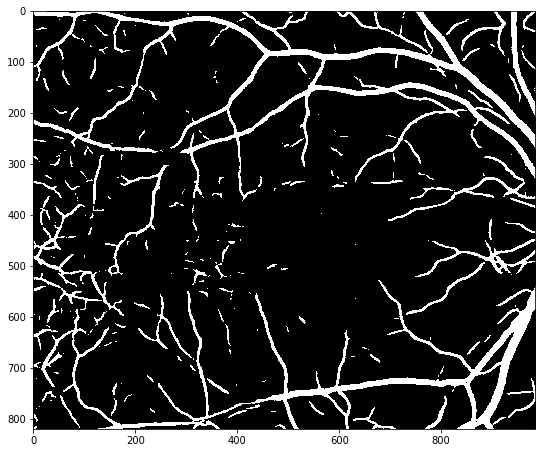

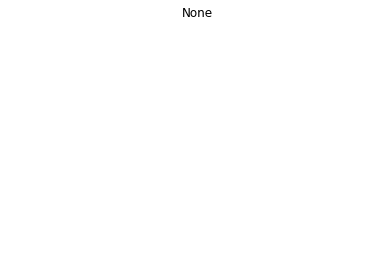

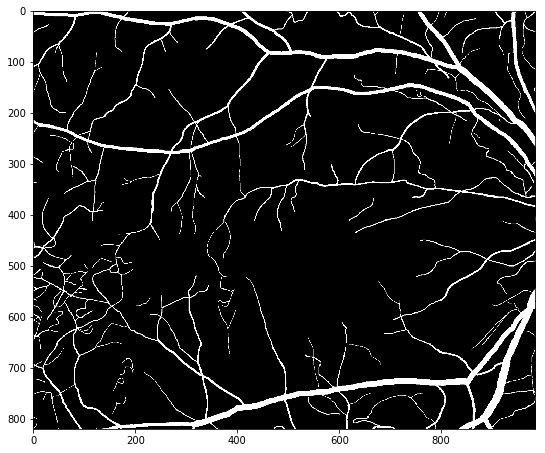

In [3]:
'''
Deep learning vessel segmentation

INPUT : segmentation imgs path (SEG_MAP_PATH)
OUTPUT : segmentation vessel imgs (SEG_VESSEL_IMGS)

'''
# Hyperparam


debug_flag = True
crop_flag = True
before_crop_size = (1848,2208)
resize_factor = 0.5
bias_more_crop_size = 50

crop_size = (int(before_crop_size[0] * resize_factor - bias_more_crop_size) , int(before_crop_size[1]*resize_factor - bias_more_crop_size))



NUM_GRD_IMGS = count_num_files(GRD_MAP_PATH)
NUM_SEG_IMGS = count_num_files(SEG_MAP_PATH)

additional_crop_flag = False

if crop_flag == False:
    SHAPE_IMGS = get_shape_of_imgs(SEG_MAP_PATH)
    SEG_VESSEL_IMGS = load_vessel_seg_map(SEG_MAP_PATH,NUM_SEG_IMGS,SHAPE_IMGS)

    GRD_VESSEL_IMGS = load_vessel_ori_map(GRD_MAP_PATH,NUM_SEG_IMGS,SHAPE_IMGS)
else:
    SHAPE_IMGS = crop_get_shape_of_imgs(SEG_MAP_PATH, crop_size)
    # SHAPE_IMGS = (874, 1054, 3) # original : 874, 1054
    
    SHAPE_IMGS = (820, 985, 3)
    # h 124 w 124
    # Output
    SEG_VESSEL_IMGS = load_vessel_seg_map(SEG_MAP_PATH,NUM_SEG_IMGS,SHAPE_IMGS, crop_flag=crop_flag, crop_size=crop_size)
    GRD_VESSEL_IMGS = load_vessel_ori_map(GRD_MAP_PATH,NUM_SEG_IMGS,SHAPE_IMGS, crop_flag, crop_size)
        
    
if debug_flag == True:
    #help_functions.show_histogram(SEG_VESSEL_IMGS[0],'gray')
    help_functions.show_on_jupyter(SEG_VESSEL_IMGS[0],'gray')
    help_functions.show_on_jupyter(GRD_VESSEL_IMGS[0],'gray')


In [4]:
import sklearn

In [5]:
temp = sklearn.metrics.confusion_matrix(GRD_VESSEL_IMGS[0].flatten(), SEG_VESSEL_IMGS[0].flatten())

print(temp)

[[691923  34468      0 ...      0      0      0]
 [  1129   1054      0 ...      0      0      0]
 [   741    757      0 ...      0      0      0]
 ...
 [   249    834      0 ...      0      0      0]
 [   347   1239      0 ...      0      0      0]
 [  8744  43962      0 ...      0      0      0]]


In [6]:
intersection = np.logical_and(GRD_VESSEL_IMGS[0].flatten(), SEG_VESSEL_IMGS[0].flatten())
union = np.logical_or(GRD_VESSEL_IMGS[0].flatten(), SEG_VESSEL_IMGS[0].flatten())
print(np.sum(intersection))
print(np.sum(union))
iou_score = np.sum(intersection) / np.sum(union)

print(iou_score)

61646
115777
0.5324546326126951


In [7]:
confusion_matrix = get_confusion_matrix_intersection_mats(GRD_VESSEL_IMGS[0],SEG_VESSEL_IMGS[0])
print(len(confusion_matrix['fp'] == False))

NameError: name 'get_confusion_matrix_intersection_mats' is not defined

In [8]:

fpr, tpr, thresholds = roc_curve(SEG_VESSEL_IMGS.flatten(), GRD_VESSEL_IMGS.flatten())


807700
(24231000,)

Area under the ROC curve: 0.8562917530853894


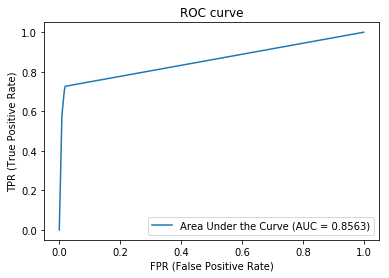

In [9]:
from matplotlib import pyplot as plt
print(820*985)
print(np.shape(SEG_VESSEL_IMGS.flatten()))
auc_roc = roc_auc_score(SEG_VESSEL_IMGS.flatten(), GRD_VESSEL_IMGS.flatten())

print ("\nArea under the ROC curve: " +str(auc_roc))
roc_curve = plt.figure()

plt.plot(fpr,tpr,'-',label='Area Under the Curve (AUC = %0.4f)' % auc_roc)
plt.title('ROC curve')
plt.xlabel("FPR (False Positive Rate)")
plt.ylabel("TPR (True Positive Rate)")
plt.legend(loc="lower right")
#plt.savefig(path_experiment+'/'+"ROC.png")


In [6]:
confusion

NameError: name 'confusion' is not defined